In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from pandas.io.json import json_normalize
import json
import os
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [3]:
def load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
#     print(df.head())
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [4]:
%%time
train = load_df()
test = load_df("/home/baitong/pywork/RevenuePrediction/all/test.csv")
train.shape, test.shape

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
Wall time: 5min 25s


In [3]:
#获取不变的常量列，模型无法在常量数据计学到东西，数据与处理时需要drop
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
train = train.drop(const_cols , axis=1)
test = test.drop(const_cols, axis=1)
####删除test中不存在的列
train = train.drop(["trafficSource.campaignCode"], axis=1)
train.shape, test.shape

NameError: name 'train' is not defined

In [6]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [7]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

In [8]:
###此处比原码多了5个属性
y_reg = y_reg.astype("float")

In [9]:
train.drop(['trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.gclId',
          'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adwordsClickInfo.page',
           'trafficSource.adwordsClickInfo.slot'],axis =1,inplace = True)
test.drop(['trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.gclId',
          'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adwordsClickInfo.page',
        'trafficSource.adwordsClickInfo.slot'],axis =1,inplace = True)

In [10]:
train.shape, test.shape

((903653, 29), (804684, 29))

In [11]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day

In [12]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

In [13]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    test[f] = indexer.get_indexer(test[f])

In [14]:
folds = get_folds(df=train, n_splits=5)

train_features = [_f for _f in train.columns if _f not in excluded_features]
print(train_features)

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x,np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

['channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom']
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.6624	valid_0's l2: 2.76357
[200]	valid_0's rmse: 1.64852	valid_0's l2: 2.71762
[300]	valid_0's rmse: 1.64468	valid_0's l2: 2.70497
[400]	valid_0's rmse: 1.64342	valid_0's l2: 2.70083
[500]	valid_0's rmse: 1.6428	valid_0's l2: 2.6988
[600]	valid_0's rmse: 1.64259	valid_0's l2: 2.6981
[700]	valid_0's rmse: 1.64197	vali

1.6378577644589039

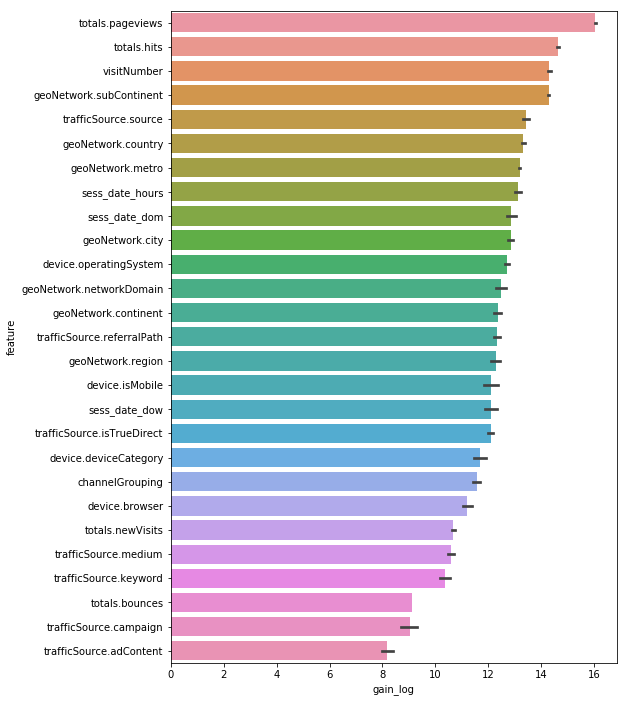

In [17]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [2]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

NameError: name 'np' is not defined

In [16]:
# Aggregate data at User level
trn_data = train[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [17]:
%%time
# Create a list of predictions for each Visitor
trn_pred_list = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
#########change by fuchao#####################
train["prepare_count"]=1;
num_session = train[['fullVisitorId', 'prepare_count']].groupby('fullVisitorId').sum()
def fun(x):
    if x>20:
        return 20
    else:
        return x
num_session['prepare_count']=num_session['prepare_count'].apply(lambda x:fun(x))
################################################

Wall time: 27.9 s


In [1]:
num_session

NameError: name 'num_session' is not defined

In [18]:
# Create a DataFrame with VisitorId as index
# trn_pred_list contains dict 
# so creating a dataframe from it will expand dict values into columns
trn_all_predictions = pd.DataFrame(list(trn_pred_list.values), index=trn_data.index)
trn_feats = trn_all_predictions.columns
trn_all_predictions['t_mean'] = np.log1p(trn_all_predictions[trn_feats].mean(axis=1))
trn_all_predictions['t_median'] = np.log1p(trn_all_predictions[trn_feats].median(axis=1))
trn_all_predictions['t_sum_log'] = np.log1p(trn_all_predictions[trn_feats]).sum(axis=1)
trn_all_predictions['t_sum_act'] = np.log1p(trn_all_predictions[trn_feats].fillna(0).sum(axis=1))
trn_all_predictions['t_nb_sess'] = trn_all_predictions[trn_feats].isnull().sum(axis=1)
trn_all_predictions=get_sess_num(trn_all_predictions)
full_data = pd.concat([trn_data, trn_all_predictions,num_session], axis=1)
del trn_data, trn_all_predictions
gc.collect()
full_data.shape

E:\anaconda\envs\tenseflow36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log1p
  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [26]:
%%time
sub_pred_list = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId')\
    .apply(lambda df: list(df.predictions))\
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
test['prepare_count']=1
test_num_session = test[['fullVisitorId', 'prepare_count']].groupby('fullVisitorId').sum()
test_num_session['prepare_count']=test_num_session['prepare_count'].apply(lambda x:fun(x))

CPU times: user 34.3 s, sys: 40.1 ms, total: 34.4 s
Wall time: 34.4 s


In [27]:
sub_data = test[train_features + ['fullVisitorId']].groupby('fullVisitorId').mean()
sub_all_predictions = pd.DataFrame(list(sub_pred_list.values), index=sub_data.index)
for f in trn_feats:
    if f not in sub_all_predictions.columns:
        sub_all_predictions[f] = np.nan
sub_all_predictions['t_mean'] = np.log1p(sub_all_predictions[trn_feats].mean(axis=1))
sub_all_predictions['t_median'] = np.log1p(sub_all_predictions[trn_feats].median(axis=1))
sub_all_predictions['t_sum_log'] = np.log1p(sub_all_predictions[trn_feats]).sum(axis=1)
sub_all_predictions['t_sum_act'] = np.log1p(sub_all_predictions[trn_feats].fillna(0).sum(axis=1))
sub_all_predictions['t_nb_sess'] = sub_all_predictions[trn_feats].isnull().sum(axis=1)

sub_full_data = pd.concat([sub_data, sub_all_predictions,test_num_session], axis=1)
del sub_data, sub_all_predictions
gc.collect()
sub_full_data.shape

(617242, 310)

In [28]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [29]:
folds = get_folds(df=full_data[['totals.pageviews']].reset_index(), n_splits=5)

oof_preds = np.zeros(full_data.shape[0])
sub_preds = np.zeros(sub_full_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = full_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = full_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_preds[oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(sub_full_data[full_data.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.39716	TRAIN's rmse: 1.54828	VALID's l2: 2.51842	VALID's rmse: 1.58695
Early stopping, best iteration is:
[130]	TRAIN's l2: 2.35298	TRAIN's rmse: 1.53394	VALID's l2: 2.50994	VALID's rmse: 1.58428
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.3867	TRAIN's rmse: 1.54489	VALID's l2: 2.54685	VALID's rmse: 1.59589
Early stopping, best iteration is:
[129]	TRAIN's l2: 2.34563	TRAIN's rmse: 1.53154	VALID's l2: 2.54231	VALID's rmse: 1.59446
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2.37389	TRAIN's rmse: 1.54074	VALID's l2: 2.57057	VALID's rmse: 1.6033
[200]	TRAIN's l2: 2.26355	TRAIN's rmse: 1.50451	VALID's l2: 2.56561	VALID's rmse: 1.60175
Early stopping, best iteration is:
[235]	TRAIN's l2: 2.23877	TRAIN's rmse: 1.49625	VALID's l2: 2.56491	VALID's rmse: 1.60153
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's l2: 2

1.5918605060603068

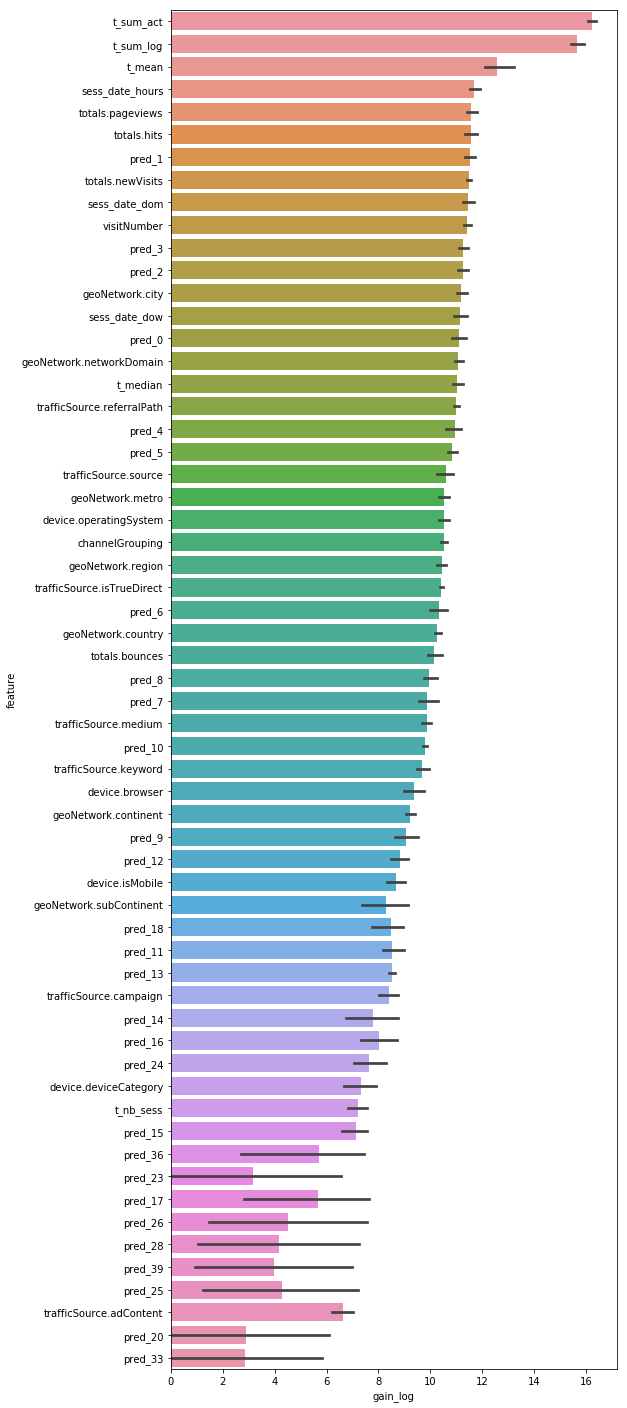

In [30]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [31]:
sub_full_data['PredictedLogRevenue'] = sub_preds
sub_full_data[['PredictedLogRevenue']].to_csv('/home/baitong/pywork/RevenuePrediction/submission.csv', index=True)